<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
#import condacolab
#condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/s7Ayo/FinRL_disso_final.git@old_version

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/s7Ayo/FinRL_disso_final.git (to revision old_version) to c:\users\simon\appdata\local\temp\pip-req-build-qpq0z01p
  Resolved https://github.com/s7Ayo/FinRL_disso_final.git to commit e4ca1e76abd519ee670267d6c212dd62abf2d627
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to c:\users\simon\appdata\local\temp\pip-install-2u2h1mq0\elegantrl_5328e944830343a5916ba6ddfe970fb6
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 155f07fcfe2d0f0a0318f820e8e2f2401ff30eca
  Preparing metadata (setup.py): started
  Preparing metadata 

  Running command git clone --filter=blob:none --quiet https://github.com/s7Ayo/FinRL_disso_final.git 'C:\Users\simon\AppData\Local\Temp\pip-req-build-qpq0z01p'
  Running command git checkout -b old_version --track origin/old_version
  branch 'old_version' set up to track 'origin/old_version'.
  Switched to a new branch 'old_version'
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git 'C:\Users\simon\AppData\Local\Temp\pip-install-2u2h1mq0\elegantrl_5328e944830343a5916ba6ddfe970fb6'



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
# Define the start and end dates for the training and testing datasets
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2024-05-08'

# Fetching the data for the defined tickers from Yahoo Finance
df = YahooDownloader(start_date=TRAIN_START_DATE,
                     end_date=TEST_END_DATE,
                     ticker_list=DOW_30_TICKER).fetch_data()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (105983, 8)


In [7]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470741,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.493397,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.090443,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.190220,7325600,CAT,0


In [8]:
df.tail()

,date,open,high,low,close,volume,tic,day
105978,2024-05-07,496.000000,501.649994,495.040009,500.959991,3751800,UNH,1
105979,2024-05-07,273.720001,277.880005,272.829987,276.459991,6376700,V,1
105980,2024-05-07,39.529999,39.580002,39.090000,39.310001,11932800,VZ,1
105981,2024-05-07,17.280001,17.570000,17.250000,17.350000,8926000,WBA,1
105982,2024-05-07,60.169998,60.799999,60.049999,60.619999,14517100,WMT,1


In [9]:
df.shape

(105983, 8)

In [10]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.470741,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,41.493397,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.090443,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777546,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,40.190220,7325600,CAT,0


In [11]:
len(df.tic.unique())

30

In [12]:
df.tic.value_counts()

tic
AAPL    3610
AMGN    3610
WMT     3610
WBA     3610
VZ      3610
V       3610
UNH     3610
TRV     3610
PG      3610
NKE     3610
MSFT    3610
MRK     3610
MMM     3610
MCD     3610
KO      3610
JPM     3610
JNJ     3610
INTC    3610
IBM     3610
HON     3610
HD      3610
GS      3610
DIS     3610
CVX     3610
CSCO    3610
CRM     3610
CAT     3610
BA      3610
AXP     3610
DOW     1293
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [22]:
INDICATORS = []

In [23]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [24]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,turbulence
75563,2020-05-11,123.595322,123.712372,121.730766,98.755051,3629382,MMM,0,31.502884
24816,2013-05-29,31.455000,31.584999,31.200001,27.811028,5521200,NKE,2,45.109987
100534,2023-10-11,331.209991,332.820007,329.140015,331.134338,20063200,MSFT,2,41.360123
57608,2017-11-21,138.449997,139.259995,138.190002,116.040985,5660600,JNJ,1,12.867973
6515,2010-11-22,33.864506,34.007633,33.568703,21.674612,15256050,MRK,0,0.000000


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [25]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 59


In [17]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [18]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [27]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [29]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  201.74083439773815
======Model training from:  2010-01-01 to  2021-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c\a2c_126_3
--------------------------------------
| time/                 |            |
|    fps                | 87         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -55.4      |
|    reward             | 0.15343033 |
|    std                | 1          |
|    value_loss         | 2.37       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps 

In [30]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-10-04,2022-01-03,A2C,0.494623,0.222339,0.124578
1,189,2022-01-03,2022-04-04,PPO,-0.249426,-0.186222,-0.295094
2,252,2022-04-04,2022-07-06,DDPG,-0.22474,-0.219566,-0.212933
3,315,2022-07-06,2022-10-04,DDPG,-0.182399,-0.192667,-0.146105
4,378,2022-10-04,2023-01-04,DDPG,0.270939,0.278017,0.289953
5,441,2023-01-04,2023-04-05,DDPG,-0.160104,-0.104662,-0.012727
6,504,2023-04-05,2023-07-07,DDPG,0.027654,0.026987,0.089874
7,567,2023-07-07,2023-10-05,DDPG,-0.26526,-0.445153,0.007087
8,630,2023-10-05,2024-01-05,DDPG,0.289629,0.359994,0.479748


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [31]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [32]:
import pandas as pd

# Create DataFrame for unique trade dates
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

# Initialize an empty DataFrame for account values
df_account_value = pd.DataFrame()

# Iterate through unique trade dates and append account values from CSV files
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv(f'results/account_value_trade_ensemble_{i}.csv')
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)

# Calculate Sharpe Ratio
sharpe = (252 ** 0.5) * df_account_value['account_value'].pct_change(1).mean() / df_account_value['account_value'].pct_change(1).std()
print('Sharpe Ratio:', sharpe)

# Join trade date DataFrame with account value DataFrame
df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

# Print the updated DataFrame
print(df_account_value)


Sharpe Ratio: 0.3071200133916769
     account_value        date  daily_return    datadate
0     1.000000e+06  2022-01-03           NaN  2022-01-03
1     1.000926e+06  2022-01-04      0.000926  2022-01-04
2     1.000072e+06  2022-01-05     -0.000854  2022-01-05
3     9.979610e+05  2022-01-06     -0.002111  2022-01-06
4     9.990834e+05  2022-01-07      0.001125  2022-01-07
..             ...         ...           ...         ...
562   1.095309e+06  2024-04-01     -0.008244  2024-04-01
563   1.084390e+06  2024-04-02     -0.009969  2024-04-02
564   1.089781e+06  2024-04-03      0.004972  2024-04-03
565   1.074142e+06  2024-04-04     -0.014350  2024-04-04
566   1.085783e+06  2024-04-05      0.010837  2024-04-05

[567 rows x 4 columns]


In [33]:
# df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

# df_account_value=pd.DataFrame()
# for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
#     temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
#     df_account_value = df_account_value.append(temp,ignore_index=True)
# sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
# print('Sharpe Ratio: ',sharpe)
# df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

In [34]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000926e+06,2022-01-04,0.000926,2022-01-04
2,1.000072e+06,2022-01-05,-0.000854,2022-01-05
3,9.979610e+05,2022-01-06,-0.002111,2022-01-06
4,9.990834e+05,2022-01-07,0.001125,2022-01-07


<Axes: >

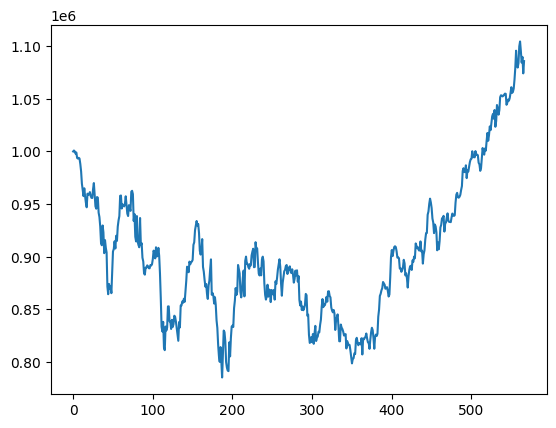

In [35]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [36]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.037256
Cumulative returns     0.085783
Annual volatility      0.161972
Sharpe ratio           0.307120
Calmar ratio           0.173070
Stability              0.108503
Max drawdown          -0.215263
Omega ratio            1.054040
Sortino ratio          0.438091
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.944153
Daily value at risk   -0.020209
dtype: float64


In [37]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (566, 8)
Annual return          0.024121
Cumulative returns     0.054993
Annual volatility      0.155363
Sharpe ratio           0.231301
Calmar ratio           0.109938
Stability              0.332939
Max drawdown          -0.219408
Omega ratio            1.040148
Sortino ratio          0.327705
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.024998
Daily value at risk   -0.019431
dtype: float64


In [38]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.005866e+06
2    2022-01-05  9.951360e+05
3    2022-01-06  9.904718e+05
4    2022-01-07  9.903404e+05
..          ...           ...
562  2024-04-01  1.081503e+06
563  2024-04-02  1.070662e+06
564  2024-04-03  1.069484e+06
565  2024-04-04  1.054993e+06
566  2024-04-05           NaN

[567 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2024-04-01  1.081503e+06
2024-04-02  1.070662e+06
2024-04-03  1.069484e+06
2024-04-04  1.054993e+06
2024-04-05           NaN

[567 rows x 1 columns]


<a id='6.2'></a>
## 7.2 BackTestPlot

df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
647  2024-05-01
648  2024-05-02
649  2024-05-03
650  2024-05-06
651  2024-05-07

[652 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2022-01-03  1.000000e+06
2022-01-04  1.000926e+06
2022-01-05  1.000072e+06
2022-01-06  9.979610e+05
2022-01-07  9.990834e+05
...                  ...
2024-04-01  1.095309e+06
2024-04-02  1.084390e+06
2024-04-03  1.089781e+06
2024-04-04  1.074142e+06
2024-04-05  1.085783e+06

[567 rows x 1 columns]
==============Compare to DJIA===========
result:                  ensemble           dji
date                                  
2022-01-03  1.000000e+06  1.000000e+06
2022-01-04  1.000926e+06  1.005866e+06
2022-01-05  1.000072e+06  9.951360e+05
2022-01-06  9.979610e+05  9.904718e+05
2022-01-07  9.990834e+05  9.903404e+05
...       

<Figure size 1500x500 with 0 Axes>

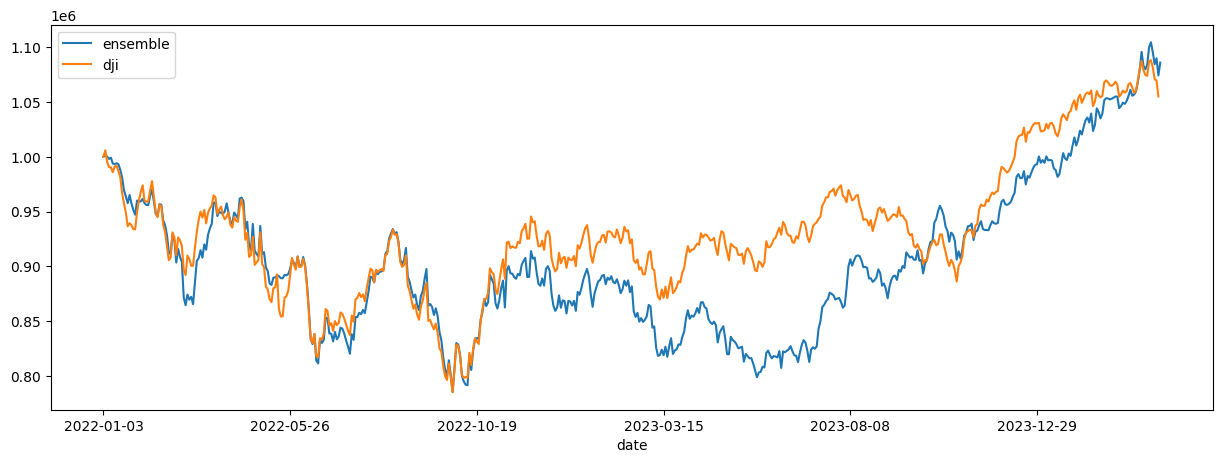

In [39]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();